In [1]:
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
from scipy.stats import poisson
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

In [2]:
dat = '../../dat/lastfm/lastfm_processed.npz'
array = np.load(dat)
A = array['adj']
Y_p = array['y_past']
Y_heldout = array['y_heldout']
Y = array['y']

In [3]:
Y.mean(), Y_p.mean(), Y_heldout.mean()

(0.013005300837017926, 0.024394825030676606, 0.005181448796802144)

In [4]:
users_to_predict = (Y_heldout.sum(axis=1) > 0)
Y_heldout.shape[0], users_to_predict.sum()

(4052, 3212)

In [5]:
out = '../../out/lastfm/'
res_pif = np.load(out + 'pif_fitted_params.npz')
res_unadj = np.load(out + 'unadjusted_fitted_params.npz')
res_spf= np.load(out + 'spf_fitted_params.npz')
res_net = np.load(out + 'network_pref_only_fitted_params.npz')
# res_item = np.load(out + 'item_only_fitted_params.npz') 

In [6]:
beta_pif = res_pif['Beta_hat']
beta_unadj = res_unadj['Beta_hat']
beta_spf = res_spf['Beta_hat']
# beta_item = res_item['Beta_hat']
beta_net = res_net['Beta_hat']

In [7]:
beta_unadj.mean(), beta_spf.mean(), beta_pif.mean(), beta_net.mean()

(0.0036490101915274847,
 0.00037661314764531604,
 0.0006274861694682044,
 0.0018330057580251027)

In [8]:
def predict(params, A, Y_p, model):
    gamma = params['Gamma_hat']
    alpha = params['Alpha_hat']
    z = params['Z_hat']
    
    if model == 'pif':
        print(z.mean())
        
    w = params['W_hat']
    beta = params['Beta_hat']
    
    rate = (beta * A).dot(Y_p)
    
    if model == 'spf' or model == 'network_pref_only':
        rate += z.dot(gamma.T)
    elif model == 'item_only':
        rate += alpha.dot(w.T)
    elif model == 'pif':
        rate += z.dot(gamma.T) + alpha.dot(w.T)
    return rate + 1e-10

def get_ll(predicted, truth, restrict_users=None):
    if restrict_users is not None:
        predicted = predicted[restrict_users,:]
        truth = truth[restrict_users,:]
    return poisson.logpmf(truth, predicted).sum(axis=1).mean()

def get_classification_metrics(pred, truth, restrict_users=None):
    if restrict_users is not None:
        pred = pred[restrict_users,:]
        truth = truth[restrict_users,:]
    return roc_auc_score(truth.flatten(), pred.flatten())
    

def get_influence_rates(params,A, Y_p):
    beta = params['Beta_hat']
    rate = (beta * A).dot(Y_p)
    mean_inf_rate = rate.mean(axis=1)
    return mean_inf_rate

In [10]:
# heldout_pif = get_ll(predict(res_pif, A, Y_p, 'pif'), Y_heldout, restrict_users=users_to_predict)
# heldout_unadjusted = get_ll(predict(res_unadj, A, Y_p, 'unadjusted'), Y_heldout, restrict_users=users_to_predict)
# heldout_spf = get_ll(predict(res_spf, A, Y_p, 'spf'), Y_heldout, restrict_users=users_to_predict)
# heldout_net = get_ll(predict(res_net, A, Y_p, 'network_pref_only'), Y_heldout, restrict_users=users_to_predict)
# heldout_item = get_ll(predict(res_item, A, Y_p, 'item_only'), Y_heldout, restrict_users=users_to_predict)

heldout_pif = get_ll(predict(res_pif, A, Y, 'pif'), Y_heldout, restrict_users=users_to_predict)
heldout_unadjusted = get_ll(predict(res_unadj, A, Y, 'unadjusted'), Y_heldout, restrict_users=users_to_predict)
heldout_spf = get_ll(predict(res_spf, A, Y, 'spf'), Y_heldout, restrict_users=users_to_predict)
heldout_net = get_ll(predict(res_net, A, Y, 'network_pref_only'), Y_heldout, restrict_users=users_to_predict)
# heldout_item = get_ll(predict(res_item, A, Y, 'item_only'), Y_heldout, restrict_users=users_to_predict)


0.04085443425128536


In [11]:
heldout_pif, heldout_unadjusted, heldout_spf, heldout_net

(-186.51668506496563,
 -349.7312481059113,
 -198.83112872329957,
 -193.44999874293384)

In [12]:
# rand_rate = np.zeros(Y_heldout.shape)
rand_rate = np.ones(Y_heldout.shape) / (Y.sum(axis=1)[:,np.newaxis])

# rand_rate = (0.05*A).dot(Y_p)
# rand_rate += 0.01*0.01*2

heldout_random = get_ll(rand_rate, Y_heldout, restrict_users=users_to_predict)
heldout_random

-421.9759061630579

In [14]:
auc_pif = get_classification_metrics(predict(res_pif, A, Y, 'pif'), Y_heldout, restrict_users=users_to_predict)
auc_unadjusted = get_classification_metrics(predict(res_unadj, A, Y, 'unadjusted'), Y_heldout, restrict_users=users_to_predict)
auc_spf = get_classification_metrics(predict(res_spf, A, Y, 'spf'), Y_heldout, restrict_users=users_to_predict)
auc_net = get_classification_metrics(predict(res_net, A, Y, 'network_pref_only'), Y_heldout, restrict_users=users_to_predict)
# auc_item = get_classification_metrics(predict(res_item, A, Y, 'item_only'), Y_heldout, restrict_users=users_to_predict)

auc_pif, auc_unadjusted, auc_spf, auc_net


0.04085443425128536


(0.6673189627396626, 0.5493587783798766, 0.658881330191263, 0.544191267600071)

In [27]:
get_influence_rates(res_pif, A, Y_p).mean(), \
get_influence_rates(res_unadj, A, Y_p).mean(), \
get_influence_rates(res_spf, A, Y_p).mean(), \
get_influence_rates(res_net, A, Y_p).mean(), \
get_influence_rates(res_item, A, Y_p).mean()

(0.00028107476466332373,
 0.010492976995504827,
 0.00012490152473026406,
 0.0015422542104267883,
 0.0008140058953315623)

In [11]:
import networkx as nx
from scipy.stats import spearmanr

def convert_to_arr(centrality):
    arr = np.array([centrality[i] for i in range(A.shape[0])])
    return arr

def calculate_corr_influence(centrality, influence):
    arr = np.array([centrality[i] for i in range(A.shape[0])])
    corr = spearmanr(influence, arr)
    return corr[0]


In [8]:
edge_list = []
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if A[i][j]:
            edge_list.append((i,j))

g = nx.Graph()
g.add_edges_from(edge_list)

In [ ]:
degree = nx.degree_centrality(g)
pagerank = nx.pagerank_numpy(g)
eigen = nx.eigenvector_centrality(g)

In [10]:
pif_results = [calculate_corr_influence(degree, beta_pif), 
               calculate_corr_influence(pagerank, beta_pif), 
               calculate_corr_influence(eigen, beta_pif)]

unadj_results = [calculate_corr_influence(degree, beta_unadj), 
               calculate_corr_influence(pagerank, beta_unadj), 
               calculate_corr_influence(eigen, beta_unadj)]

df = pd.DataFrame([pif_results, unadj_results], columns=['Degree centrality', 'Pagerank', 'Eigenvector centrality'], index=['PIF', 'Unadjusted'])
df

,Degree centrality,Pagerank,Eigenvector centrality
PIF,-0.600394,-0.520733,-0.624198
Unadjusted,-0.312366,-0.204206,-0.394596


In [122]:
deg_arr = A.sum(axis=1)

X = Y_p.copy()
X[X>1] = 1
copurchase = (X * (A.dot(Y))).sum(axis=1)
# copurchase /= A.sum(axis=1)

idx = beta_pif.argsort()[-20:]
deg_arr[idx], copurchase[idx]

(array([ 38.,  13.,  25.,  92.,  68.,  22.,  72.,  28.,  47.,  38.,  62.,
         83.,  49.,  62., 102., 117.,  28.,  25.,  30.,  14.]),
 array([14.,  3., 20., 24., 14.,  3., 21.,  1., 60.,  2., 18., 30., 13.,
         5., 22., 16.,  9.,  7.,  4.,  3.]))

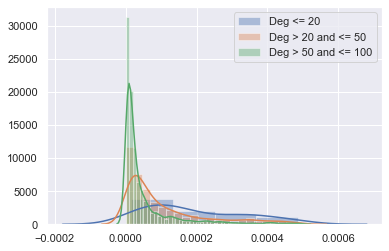

In [118]:
import matplotlib.pyplot as plt

# deg = g.degree()
# deg_arr = convert_to_arr(deg)

deg_arr = A.sum(axis=1)

indices_1 = np.where(deg_arr <= 20)
indices_2 = np.where((deg_arr > 20) & (deg_arr <=75))
indices_3 = np.where((deg_arr > 75) & (deg_arr <=150))
b1 = beta_pif[indices_1]
b2 = beta_pif[indices_2]
b3 = beta_pif[indices_3]
# data = {'Deg <= 20':beta_pif[indices_1],
#        'Deg > 20 and <= 50':beta_pif[indices_2],
#        'Deg > 50 and <= 100':beta_pif[indices_3]}
sns.distplot(b1[b1 <= 0.0005], label='Deg <= 20')
sns.distplot(b2[b2 <= 0.0005], label='Deg > 20 and <= 50')
sns.distplot(b3[b3 <= 0.0005], label='Deg > 50 and <= 100')
plt.legend()
plt.show()
# sns.scatterplot(deg_arr[indices], beta_pif[indices])
# sns.scatterplot(deg_arr, beta_pif)

In [108]:
X = Y_p.copy()
X[X>1] = 1
copurchase = (X * (A.dot(Y))).sum(axis=1)
copurchase /= A.sum(axis=1)

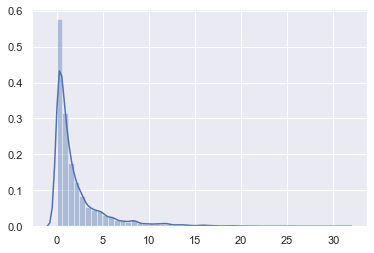

In [109]:
sns.distplot(copurchase)

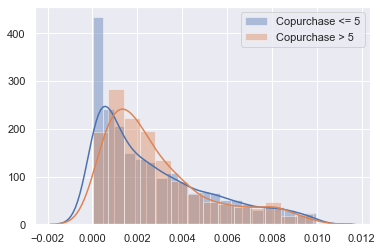

In [114]:
indices_1 = np.where(copurchase <= 5)
indices_2 = np.where(copurchase > 5)
b1 = beta_unadj[indices_1]
b2 = beta_unadj[indices_2]
# b3 = beta_unadj[indices_3]

sns.distplot(b1[b1 <= 0.01], label='Copurchase <= 5', kde=True)
sns.distplot(b2[b2 <= 0.01], label='Copurchase > 5', kde=True)
# sns.distplot(b3[b3 <= 0.01], label='Copurchase > 400', kde=True)
plt.legend()
plt.show()

In [117]:
spearmanr(copurchase, beta_unadj), spearmanr(copurchase, beta_pif)

(SpearmanrResult(correlation=0.057361062439635145, pvalue=0.00022581593981799405),
 SpearmanrResult(correlation=-0.6488501479289093, pvalue=0.0))

In [ ]:
indices_1 = np.where(copurchase <= 50)
indices_2 = np.where((copurchase > 100) & (copurchase <=400))
indices_3 = np.where((copurchase > 400))
b1 = beta_pif[indices_1]
b2 = beta_pif[indices_2]
b3 = beta_pif[indices_3]

sns.distplot(b1[b1 <= 0.001], label='Copurchase <= 50', kde=True)
sns.distplot(b2[b2 <= 0.001], label='Copurchase > 100 and <= 400', kde=True)
sns.distplot(b3[b3 <= 0.001], label='Copurchase > 400', kde=True)
plt.legend()
plt.show()

In [64]:
overlap = []
per_item_overlap = np.zeros(Y.shape[1])
row_idx, col_idx = np.nonzero(A)
for (i,j) in zip(row_idx, col_idx):
    i1 = np.nonzero(Y[i,:])[0]
    i2 = np.nonzero(Y_p[j,:])[0]
    intersect = np.intersect1d(i1, i2)
    overlap.append(intersect.shape[0])
    for k in intersect:
        per_item_overlap[k] += 1

In [58]:
overlap = np.array(overlap)
overlap.mean(), (overlap > 0).sum()/overlap.shape[0]

# import matplotlib.pyplot as plt
# plt.hist(overlap)
# plt.xlim(0, 200)
# np.histogram(overlap)

(2.9364837135834545, 0.5189749854223101)

In [67]:
items = (per_item_overlap > 100)

In [69]:
selected_overlap = []

for (i,j) in zip(row_idx, col_idx):
    i1 = np.nonzero(Y[i,items])[0]
    i2 = np.nonzero(Y_p[j,items])[0]
    intersect = np.intersect1d(i1, i2)
    selected_overlap.append(intersect.shape[0])


In [71]:
selected_overlap = np.array(selected_overlap)
selected_overlap.mean(), (selected_overlap > 0).sum()/selected_overlap.shape[0]

(2.779295620788155, 0.506659605405924)

In [30]:
n = A.shape[0]
betas = np.hstack([beta_unadj, beta_net, beta_item, beta_spf, beta_pif])
method_names = ['unadjusted']*n + ['network only']*n + ['item only']*n + ['spf']*n + ['pif']*n
df = pd.DataFrame(np.array([betas, method_names]).T, columns=['beta', 'method'])
df = df.astype({'beta': 'float'})

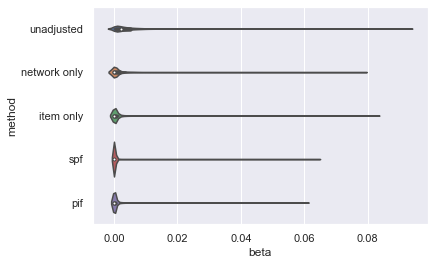

In [33]:
sns.violinplot(x='beta', y='method', data=df)